In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.optimize import curve_fit
import itertools
from cycler import cycler
import glob
import os

def param_from_fname(fname, param, delim="_", rm_ext=True):
    if rm_ext:
        fname = os.path.splitext(fname)[0]
    s = [x.split("=") for x in fname.split("/")[-1].split(delim)]
    for idx, value in enumerate(s):
        if value[0] == param:
            return value[1]

In [10]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 8})
plt.rc('font', family='Helvetica')

## Loading files for scaling analysis simulations

Each file contains the retrieval accuracies from a simulation performed with $n_p$ patterns and $n_s$ neurons, repeated over ~40 iterations

In [61]:
files = glob.glob("capacity_data/*npz")
all_files = {}
for file in files:
    try:
        arr = np.hstack(list(np.load(file).values()))
    except:
        arr = np.array([])
    all_files[file] = arr
    



np_arr = []
ns_arr = []
net_types = []
it_arr = []
for key in all_files.keys():
    np_arr.append(param_from_fname(key, "np"))
    ns_arr.append(param_from_fname(key, "ns"))
    net_types.append(param_from_fname(key, "nettype"))
#     it_arr.append(param_from_fname(key, "it"))

np_set = list(set(np_arr))
np_set = [x for x in np_set if x is not None]
np_set = sorted(np.array(np_set).astype(int))

ns_set = list(set(ns_arr))
ns_set = [x for x in ns_set if x is not None]
ns_set = sorted(np.array(ns_set).astype(int))

net_types_set = ["SK", "HU", "MAI", "MSI"]

data = {}
for nt in net_types_set:
    data[nt] = {}
    for ns in ns_set:
        data[str(nt)][str(ns)] = {}
        for n_p in np_set:
            data[nt][str(ns)][str(n_p)] = []
            
file_zip = zip(ns_arr, np_arr, net_types, all_files.values())

for ns, n_p, nt, arr in file_zip:
    try:
        data[nt][ns][n_p].append(arr)
    except: None

for nt in net_types_set:
    for ns in ns_set:
        for n_p in np_set:
            try:
                arr = np.concatenate(data[nt][str(ns)][str(n_p)])
                arr = arr.ravel()
                data[nt][str(ns)][str(n_p)] = (np.nanmean(arr), np.nanstd(arr))
                if np.isnan(np.nanmean(arr)):
                    data[nt][str(ns)][str(n_p)] = (0,0)
            except:
                data[nt][str(ns)][str(n_p)] = (np.nan, np.nan)
    
d = {} # dictionary of simulation trajectories
for nt in net_types_set:
    a = []
    for ns in ns_set:
        arr = []
        for n_p in np_set:
                arr.append(data[nt][str(ns)][str(n_p)][0])                
        a.append(arr)
    d[nt] = np.stack(a)

/var/folders/m6/d33f9cts3cnglkrymdy1gxxh0000gn/T/ipykernel_33959/1536674832.py:54: RuntimeWarning: Mean of empty slice
  data[nt][str(ns)][str(n_p)] = (np.nanmean(arr), np.nanstd(arr))
/var/folders/m6/d33f9cts3cnglkrymdy1gxxh0000gn/T/ipykernel_33959/1536674832.py:55: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(arr)):


## Fitting retrieval curves to determine capacity for each network size

In [62]:
def f(x, a, c, d):
    val = d/(1+np.exp(a*(np.log(x)-c)))
    if a < 0 or c < 0:
        val = 0
    return val

cutoff_d = {}
for nt, tss in d.items():
    c_est_arr = []
    a_est_arr = []
    d_est_arr = []

    for arr in tss[:-1]:
        ts = arr.copy()
        ts[np.isnan(ts)] = 0
        (idxs,) = np.where(ts==0)
        n_p = np.delete(np_set, idxs)
        ts = np.delete(ts, idxs)
        params, _ = curve_fit(f, n_p, ts, maxfev=100000, 
                              bounds=([0.,0.,0.],[12,12,1]))
        d_est = params[2]
        c_est = params[1]
        a_est = params[0]
        a_est_arr.append(a_est)
        c_est_arr.append(c_est)
        d_est_arr.append(d_est)

    cutoff_d[nt] = [a_est_arr, c_est_arr, d_est_arr]

[None, None]

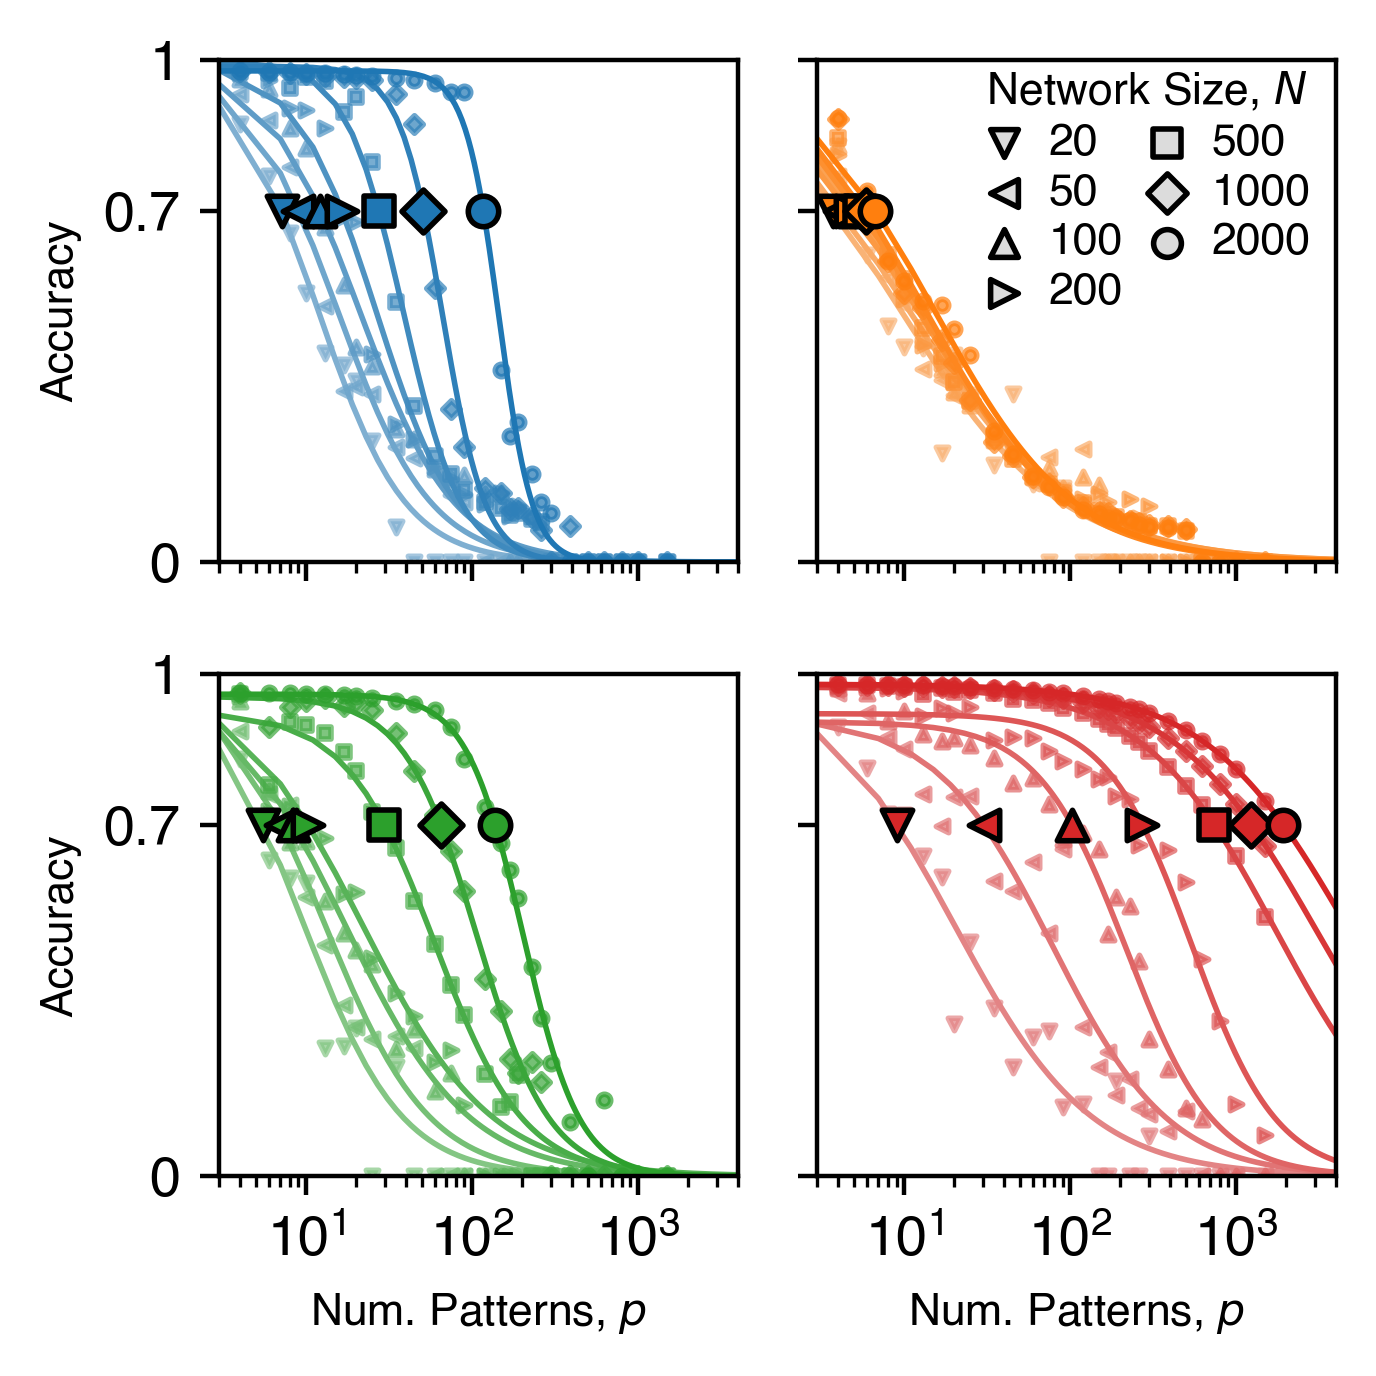

In [63]:
cmap_qual = sns.color_palette("tab10", n_colors=4, as_cmap=False)
score=0.7
fig, axs = plt.subplots(2,2, figsize=(3.54,3.54), tight_layout=True, dpi=400)
axs = np.ravel(axs)
markers=['v', '<', '^', '>', 's', 'D', 'o']

name_arr = ["SK", "HU", "MAI", "MSI"]
for idx, (nt, ax) in enumerate(zip(net_types_set, axs)):
    
    cmap_sequential = sns.light_palette(cmap_qual[idx], 
                                        n_colors=2*d[nt][:-1,:].shape[0], 
                                        as_cmap=False)
        
    values = np.array(list(cutoff_d.values()))[idx]    

    (row,col) = np.array(values).shape
    ps_arr = []
    for i in range(col):
        (a,c,d_) = np.array(values)[:,i]

        ax.scatter(np_set, d[nt][i], marker=markers[i], s=5, lw=1, 
             color=cmap_sequential[i+d[nt][:-1,:].shape[0]], alpha=0.7, zorder=-1)
        x = np.linspace(3,4000,1000)
        ax.plot(x, (f(x, a, c, d_)), lw=1, ls="-",
                 color=cmap_sequential[i+d[nt][:-1,:].shape[0]], alpha=1, zorder=-1)
        ps = np.exp(1/a*np.log(d_/score-1) + c)   
        ax.scatter(ps, score, s=30, marker=markers[i],
                    color=cmap_qual[idx], edgecolor="black", zorder=2)
        ax.scatter(np.nan, score, s=40, marker=markers[i], label=ns_set[i],
                    color="gainsboro", edgecolor="black", zorder=2)
    ax.set_ylim(0,1)
    ax.set_xlim(3,4000)
    ax.set_xscale('log')
    
axs = np.reshape(axs, (2,2))
axs[0,0].set_ylabel(r"Accuracy", fontsize=8)
axs[0,0].set_yticks(ticks=[0,0.7,1])
axs[0,0].set_yticklabels(list(map(str, [0,0.7,1])))
axs[0,0].set_xticklabels([])

axs[1,0].set_ylabel(r"Accuracy", fontsize=8)
axs[1,0].set_yticks(ticks=[0,0.7,1])
axs[1,0].set_yticklabels(list(map(str, [0,0.7,1])))
axs[1,0].set_xlabel("Num. Patterns, $p$", fontsize=8)

axs[1,1].set_yticks(ticks=[0,0.7,1])
axs[1,1].set_yticklabels([])

axs[1,1].set_xlabel("Num. Patterns, $p$", fontsize=8)

legend = axs[0,1].legend(ncol=2, title=r"  Network Size, $N$", prop={'size': 8}, 
                loc=(0.24,0.46), fancybox=False, framealpha=0.,
                handletextpad=0.,edgecolor="black",fontsize=8,labelspacing=0.2,columnspacing=0)

for handle in legend.legendHandles:
    handle.set_sizes([25])

axs[0,1].set_yticks(ticks=[0,0.7,1])
axs[0,1].set_yticklabels([])

axs[0,1].set_xticklabels([])

plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.setp(legend.get_title(),fontsize=8)

## Fitting capacities to network size

Text(0, 0.5, 'Dynamic Storage Capacity, $\\alpha_\\mathrm{D}$')

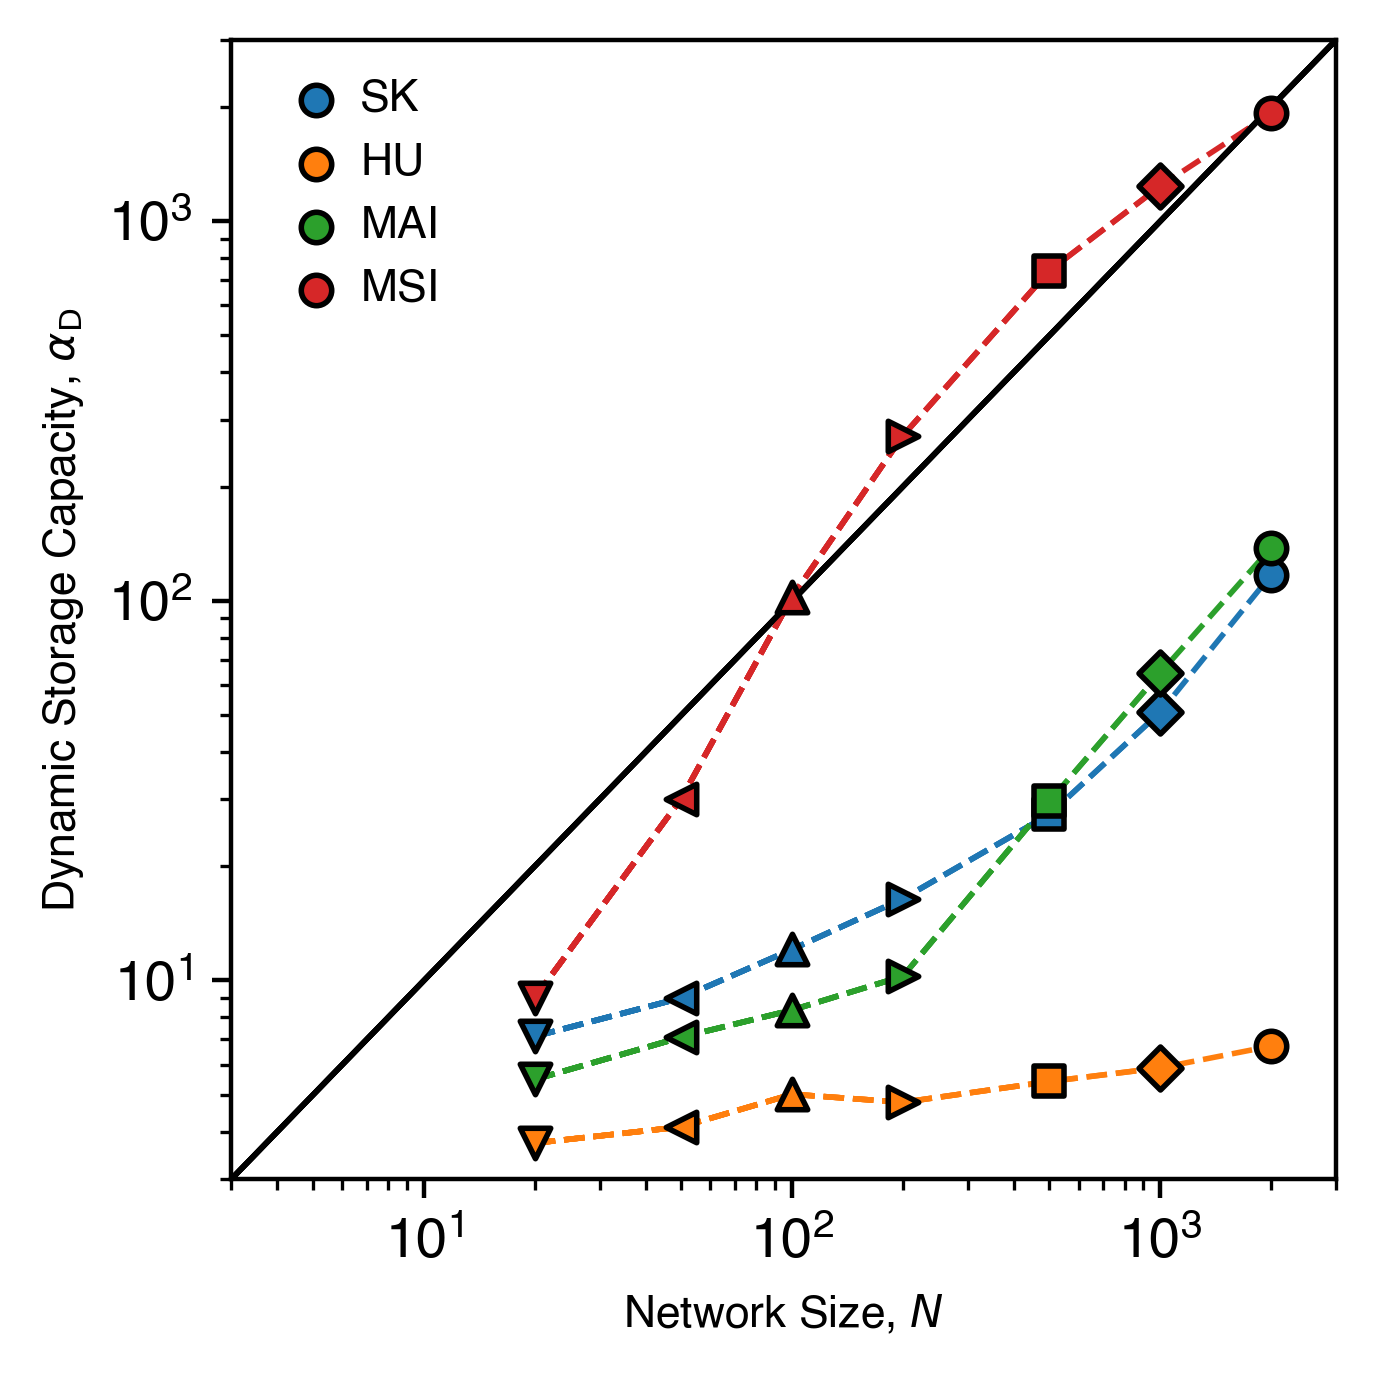

In [64]:
def g(x, a, b, c):
    val = a*np.log(x) + b
    return np.exp(val)

score=0.7

name_arr = ["SK", "HU", "MAI", "MSI"]
fig, ax = plt.subplots(1,1, figsize=(3.54,3.54), tight_layout=True, dpi=400)
markers=['v', '<', '^', '>', 's', 'D', 'o',]
colors=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
for idx, (key, value) in enumerate(cutoff_d.items()):

    (row,col) = np.array(value).shape
    ps_arr = []
    for i in range(col):
        (a,c,d_) = np.array(value)[:,i]
        ps = np.exp(1/a*np.log(d_/score-1) + c)
        if i == col-1:
            ax.scatter(ns_set[:-1][i], ps,s=30, marker=markers[i],
                   color=colors[idx], edgecolor="black", label=name_arr[idx])
            
        else:
            ax.scatter(ns_set[:-1][i], ps,s=30, marker=markers[i], 
                   color=colors[idx], edgecolor="black")
            
        ps_arr.append(ps)
        ax.plot(ns_set[:len(ps_arr)], ps_arr,lw=1,
               color=colors[idx], zorder=-1, ls="--")

    ax.plot(np.linspace(0,3500,1000), np.linspace(0,3500,1000), c='k', lw=1, zorder=-1)
    params, _ = curve_fit(g, ns_set[:-1][-3:], ps_arr[-3:])
    x = np.linspace(ns_set[:-1][-3], ns_set[:-1][-1],1000)

    ax.set_xscale("log")
    ax.set_yscale("log")

ax.legend(loc="upper left", prop={'size': 8}, framealpha=0., handletextpad=0.)
ax.set_ylim(3,3000)
ax.set_xlim(3,3000)
ax.set_xlabel("Network Size, $N$", fontsize=8)
ax.set_ylabel(r"Dynamic Storage Capacity, $\alpha_\mathrm{D}$", fontsize=8)

